## Real World

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import scipy.stats as stats
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.utils import resample
from sklearn.model_selection import cross_val_score, KFold

## OOB Method

In [2]:
def power_RW_OOB(n,B):
        
   np.random.seed(42)
   esperances = []
   variances = []
   test_statistics = []
   test_alternative = []
   power = []
   epsilon = np.random.normal(0, 1, n)
   x = np.random.uniform(0, 5, n)
   beta1 = 2
   beta2_values = np.linspace(0, 0.16, 9)

   bootstrap_indices = np.random.choice(n, size=(B, n), replace=True) # bootstrapping

   for beta2 in beta2_values:
       
       y = beta1 * x + beta2 * x**2 + epsilon # generation de données
       db = []
       
       for bootstrap_index in bootstrap_indices:
       
          oob_indices = np.setdiff1d(np.arange(n), bootstrap_indices, assume_unique=True)
          x_train = x[bootstrap_index]
          y_train = beta1 * x_train + beta2 * x_train**2 + epsilon[bootstrap_index]

          mask = np.ones(len(x), dtype=bool)
          mask[bootstrap_index] = False

          x_test = x[mask]
          y_test = y[mask]

          x_train_reshape = x_train.reshape(-1, 1)
          x_test_reshape = x_test.reshape(-1,1)

          model_a1 = LinearRegression().fit(x_train_reshape, y_train) # Modèle linéaire
          y_pred_a1 = model_a1.predict(x_test_reshape.reshape(-1,1))
          p1b = mean_squared_error(y_test, y_pred_a1)

          x_train_quad = np.column_stack((x_train_reshape, x_train**2))
          x_test_quad = np.column_stack((x_test_reshape, x_test**2))


          model_a2 = LinearRegression().fit(x_train_quad, y_train)
          y_pred_a2 = model_a2.predict(x_test_quad)
          p2b = mean_squared_error(y_test, y_pred_a2)

          db.append(p1b - p2b)  # Différence des moyennes de performance sur chaque bootstrap

       # Fin du boostrapping

       d_barre = sum(db)/B # Converge p.s vers l'espérance mu

       var = np.var(db, ddof=1)
       test_stat = (B**0.5)*d_barre/np.sqrt(var) # Statistique pour l'hypothèse nulle

       delta = d_barre
       student = stats.t.ppf(0.95, df=B-1)
       mu = (B ** 0.5)*delta/np.sqrt(var)
       test_alt = student - mu
       puissance = 1 - stats.norm.cdf(student - mu, 0, 1)
       
       esperances.append(d_barre)
       variances.append(var)
       test_statistics.append(test_stat)
       test_alternative.append(test_alt)
       power.append(puissance)

   return esperances, variances, test_statistics, test_alternative, power


In [3]:
esperances, variances, test_statistics, test_alternative, power = power_RW_OOB(n=150, B=100)
print(f"Espérances: {esperances}")
print(f"Variances: {variances}")
print(f"Statistiques de test: {test_statistics}")
print(f"Test alternative: {test_alternative}")
print(f"Puissance: {power}")


Espérances: [-0.014342453796800414, -0.012583576406822677, -0.007706624994478464, 0.000288400440232115, 0.011401499897309007, 0.025632673376752246, 0.042981920878561945, 0.06344924240273796, 0.0870346379492802]
Variances: [0.00034803318391867546, 0.0003706740467440903, 0.0005107046367346388, 0.0007661387926894189, 0.0011359325361939947, 0.0016199840716204323, 0.002219133786127247, 0.0029351642496594703, 0.0037708002149485567]
Statistiques de test: [-7.687995708080356, -6.535939158375998, -3.4101958867183546, 0.10419387563055872, 3.382873189601895, 6.368520210501451, 9.124184899933303, 11.711438343967394, 14.173443130216222]
Test alternative: [9.348386864076746, 8.196330314372387, 5.070587042714744, 1.5561972803658308, -1.7224820336055056, -4.708129054505061, -7.463793743936913, -10.051047187971005, -12.513051974219833]
Puissance: [0.0, 1.1102230246251565e-16, 1.982952391177406e-07, 0.05983059394703982, 0.9575088826772802, 0.999998749995946, 0.9999999999999579, 1.0, 1.0]


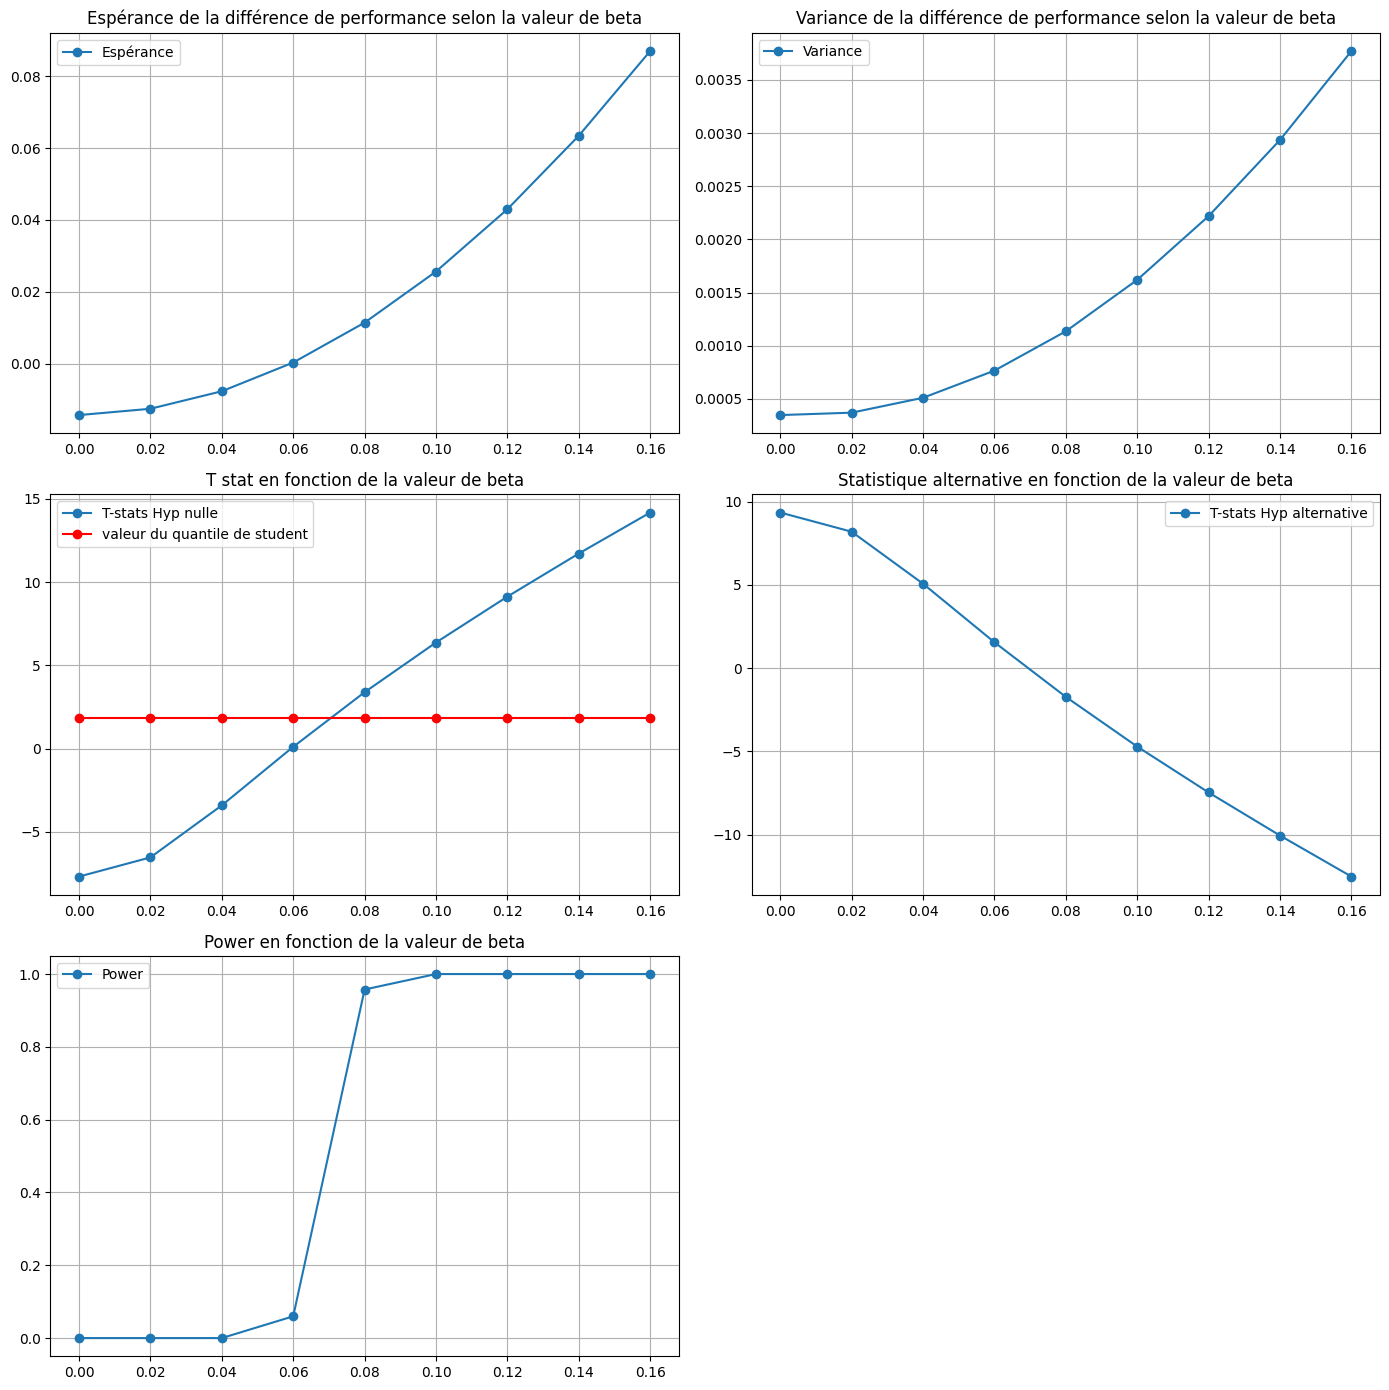

In [4]:
esperances, variances, test_statistics, test_alternative, power = power_RW_OOB(150, 100)
beta2_values = np.linspace(0, 0.16, 9)
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(14, 14))

# Premier sous-graphe : Espérance
axes[0, 0].plot(beta2_values, esperances, label='Espérance', marker='o')
axes[0, 0].set_title('Espérance de la différence de performance selon la valeur de beta')
axes[0, 0].legend()
axes[0, 0].grid(True)

# Deuxième sous-graphe : Variance
axes[0, 1].plot(beta2_values, variances, label='Variance', marker='o')
axes[0, 1].set_title('Variance de la différence de performance selon la valeur de beta')
axes[0, 1].legend()
axes[0, 1].grid(True)

# Troisième sous-graphe : T-stat Hyp nulle
axes[1, 0].plot(beta2_values, test_statistics, label='T-stats Hyp nulle', marker='o')
axes[1, 0].plot(beta2_values, [stats.t.ppf(0.95, df=9)]*len(beta2_values), label='valeur du quantile de student', color='r', marker='o')
axes[1, 0].set_title('T stat en fonction de la valeur de beta')
axes[1, 0].legend()
axes[1, 0].grid(True)

# Quatrième sous-graphe : T-stat Hyp alternative
axes[1, 1].plot(beta2_values, test_alternative, label='T-stats Hyp alternative', marker='o')
axes[1, 1].set_title('Statistique alternative en fonction de la valeur de beta')
axes[1, 1].legend()
axes[1, 1].grid(True)

# Cinquième sous-graphe : Power
axes[2, 0].plot(beta2_values, power, label='Power', marker='o')
axes[2, 0].set_title('Power en fonction de la valeur de beta')
axes[2, 0].legend()
axes[2, 0].grid(True)

# Cache le 6ème sous-graphe vide
fig.delaxes(axes[2, 1])

# Ajuste la disposition pour éviter les chevauchements
plt.tight_layout()
plt.show()

## Cross Validation Method

In [5]:
def power_RW_CV(n, B):
    np.random.seed(42)
    esperances = []
    variances = []
    test_statistics = []
    test_alternative = []
    power = []
    epsilon = np.random.normal(0, 1, n)
    x = np.random.uniform(0, 5, n)
    beta1 = 2
    beta2_values = np.linspace(0, 0.16, 9)
    
    # Generate bootstrap indices
    bootstrap_indices = np.random.choice(n, size=(B, n), replace=True)

    for beta2 in beta2_values:
        db = []

        for bootstrap_index in bootstrap_indices:
            # Generate data
            y = beta1 * x + beta2 * x**2 + epsilon

            x_train = x[bootstrap_index]
            y_train = beta1 * x_train + beta2 * x_train**2 + epsilon[bootstrap_index]
    
            # Cross-validation setup
            kf = KFold(n_splits=5)
            cv_scores_linear = []
            cv_scores_quadratic = []

            for train_index, test_index in kf.split(x_train):
                x_train_cv, x_test_cv = x_train[train_index], x_train[test_index]
                y_train_cv, y_test_cv = y_train[train_index], y_train[test_index]

                # Linear model
                model_a1 = LinearRegression().fit(x_train_cv.reshape(-1, 1), y_train_cv)
                y_pred_a1 = model_a1.predict(x_test_cv.reshape(-1, 1))
                mse_a1 = mean_squared_error(y_test_cv, y_pred_a1)
                cv_scores_linear.append(mse_a1)

                # Quadratic model
                x_train_cv_quad = np.column_stack((x_train_cv, x_train_cv**2))
                x_test_cv_quad = np.column_stack((x_test_cv, x_test_cv**2))
                model_a2 = LinearRegression().fit(x_train_cv_quad, y_train_cv)
                y_pred_a2 = model_a2.predict(x_test_cv_quad)
                mse_a2 = mean_squared_error(y_test_cv, y_pred_a2)
                cv_scores_quadratic.append(mse_a2)

            p1b = np.mean(cv_scores_linear)
            p2b = np.mean(cv_scores_quadratic)

            db.append(p1b - p2b)  # Difference in performance means for each bootstrap

        # End of bootstrapping
        d_barre = sum(db) / B  # Sample mean

        var = np.var(db, ddof=1)
        test_stat = (B**0.5) * d_barre / np.sqrt(var)  # Test statistic under null hypothesis

        delta = d_barre
        student = stats.t.ppf(0.95, df=B-1)
        mu = (B**0.5) * delta / np.sqrt(var)
        test_alt = student - mu
        puissance = 1 - stats.norm.cdf(student - mu, 0, 1)

        esperances.append(d_barre)
        variances.append(var)
        test_statistics.append(test_stat)
        test_alternative.append(test_alt)
        power.append(puissance)

    return esperances, variances, test_statistics, test_alternative, power


In [7]:
esperances_CV, variances_CV, test_statistics_CV, test_alternative_CV, power_CV = power_RW_CV(n=150, B=100)
print(f"Espérances: {esperances_CV}")
print(f"Variances: {variances_CV}")
print(f"Statistiques de test: {test_statistics_CV}")
print(f"Test alternative: {test_alternative_CV}")
print(f"Puissance: {power_CV}")


Espérances: [-0.007646746048875811, -0.005714246028842388, -0.0008515772330552906, 0.006941260338485439, 0.017664266685779823, 0.031317441808827826, 0.047900785707629366, 0.06741429838218477, 0.08985797983249362]
Variances: [8.424194952833782e-05, 9.630253467328011e-05, 0.00015921997809714518, 0.0002721592155149344, 0.0004346934052200607, 0.0006468039280843726, 0.0009088803875581317, 0.0012217206096700125, 0.001586530643027118]
Statistiques de test: [-8.331294049581883, -5.8229099811612475, -0.6748779861608818, 4.207526026873936, 8.472353873294168, 12.314022839298229, 15.888733148312692, 19.28706165655095, 22.559653156835914]
Test alternative: [9.991685205578273, 7.483301137157637, 2.335269142157271, -2.547134870877546, -6.811962717297778, -10.653631683301839, -14.228341992316302, -17.62667050055456, -20.899262000839524]
Puissance: [0.0, 3.6193270602780103e-14, 0.009764682563415783, 0.9945694276383984, 0.9999999999951862, 1.0, 1.0, 1.0, 1.0]


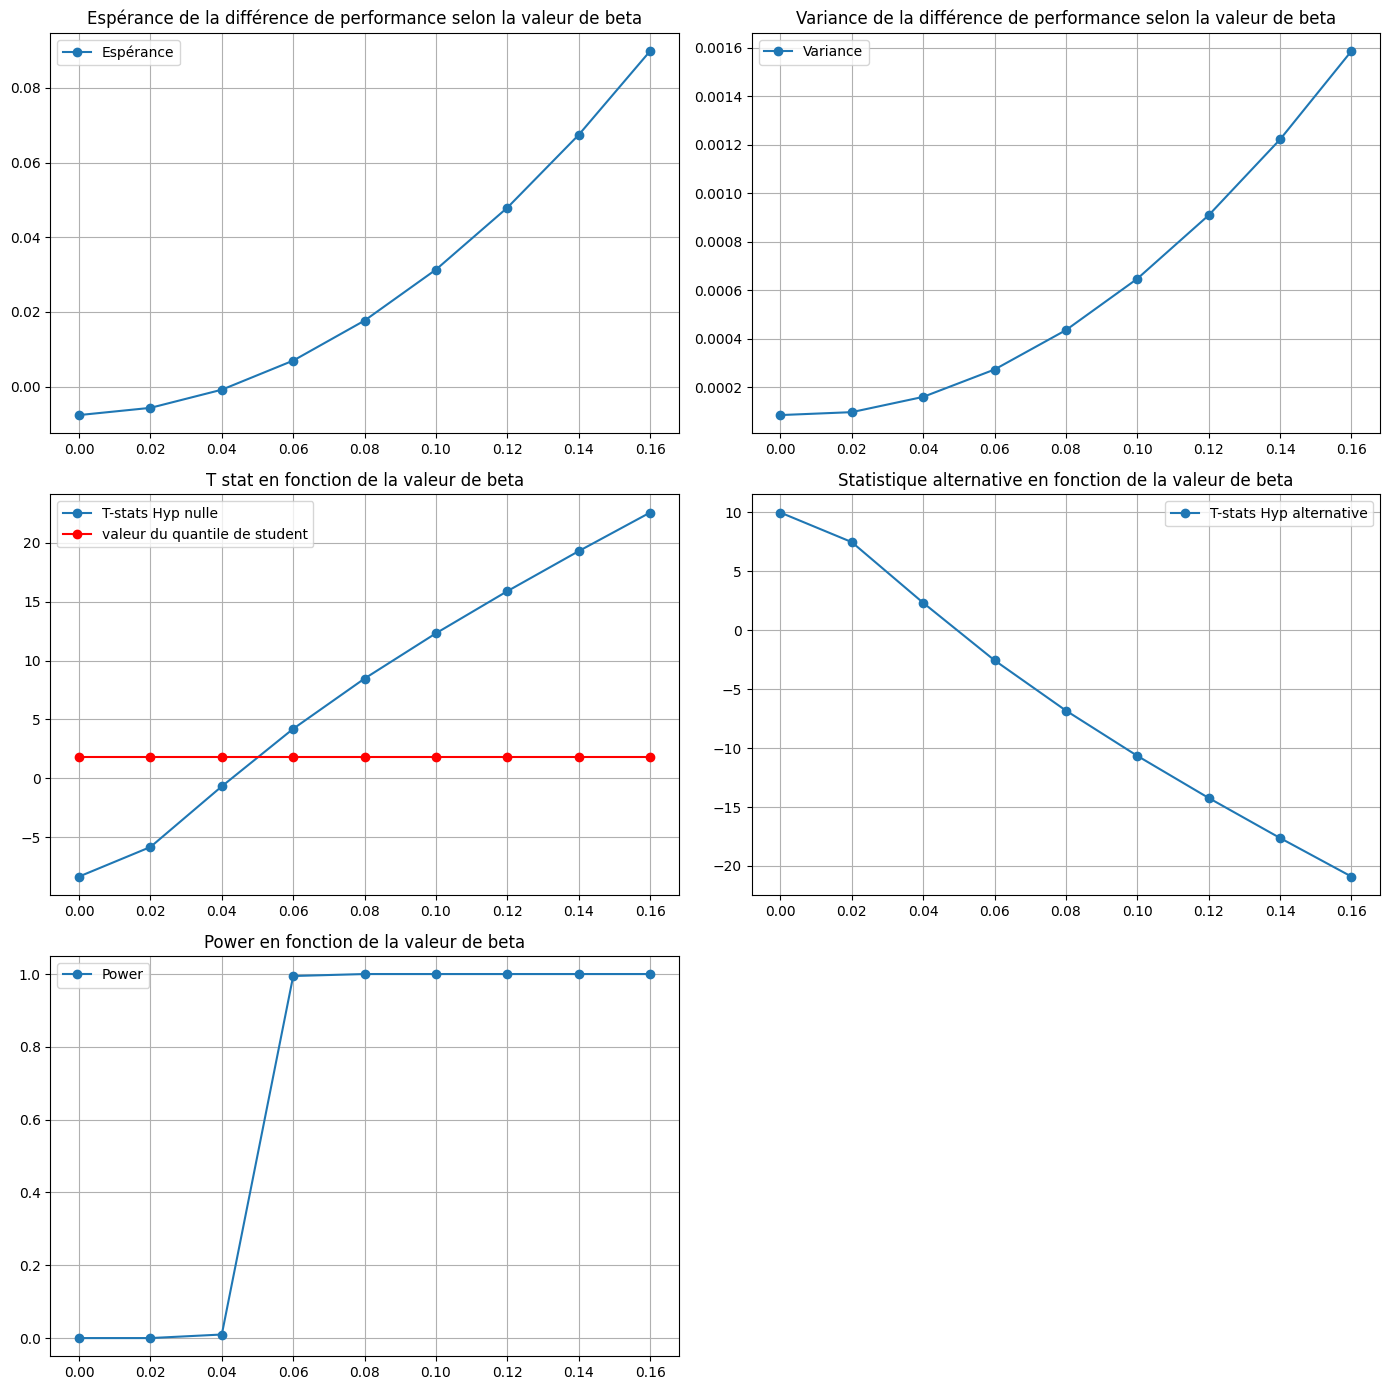

In [9]:
esperances_CV, variances_CV, test_statistics_CV, test_alternative_CV, power_CV = power_RW_CV(150, 100)
beta2_values = np.linspace(0, 0.16, 9)
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(14, 14))

# Premier sous-graphe : Espérance
axes[0, 0].plot(beta2_values, esperances_CV, label='Espérance', marker='o')
axes[0, 0].set_title('Espérance de la différence de performance selon la valeur de beta')
axes[0, 0].legend()
axes[0, 0].grid(True)

# Deuxième sous-graphe : Variance
axes[0, 1].plot(beta2_values, variances_CV, label='Variance', marker='o')
axes[0, 1].set_title('Variance de la différence de performance selon la valeur de beta')
axes[0, 1].legend()
axes[0, 1].grid(True)

# Troisième sous-graphe : T-stat Hyp nulle
axes[1, 0].plot(beta2_values, test_statistics_CV, label='T-stats Hyp nulle', marker='o')
axes[1, 0].plot(beta2_values, [stats.t.ppf(0.95, df=9)]*len(beta2_values), label='valeur du quantile de student', color='r', marker='o')
axes[1, 0].set_title('T stat en fonction de la valeur de beta')
axes[1, 0].legend()
axes[1, 0].grid(True)

# Quatrième sous-graphe : T-stat Hyp alternative
axes[1, 1].plot(beta2_values, test_alternative_CV, label='T-stats Hyp alternative', marker='o')
axes[1, 1].set_title('Statistique alternative en fonction de la valeur de beta')
axes[1, 1].legend()
axes[1, 1].grid(True)

# Cinquième sous-graphe : Power
axes[2, 0].plot(beta2_values, power_CV, label='Power', marker='o')
axes[2, 0].set_title('Power en fonction de la valeur de beta')
axes[2, 0].legend()
axes[2, 0].grid(True)

# Cache le 6ème sous-graphe vide
fig.delaxes(axes[2, 1])

# Ajuste la disposition pour éviter les chevauchements
plt.tight_layout()
plt.show()